# Creating Topography Variables

In [1]:
%load_ext jupyter_black
from bs4 import BeautifulSoup
import requests
from pathlib import Path
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import richdem as rd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

In [2]:
base_url = Path(os.getenv("STORM_DATA_DIR")) / "analysis/02_new_model_input/"
input_dir = base_url / "04_topography/input/srtm/"
output_dir = base_url / "04_topography/output/"
shp_output_dir = base_url / "02_housing_damage/output/"

In [3]:
grid = gpd.read_file(shp_output_dir / "phl_0.1_degree_grid_land_overlap.gpkg")

In [27]:
adm3_shp = gpd.read_file(
    base_url / "02_housing_damage/input/phl_adminboundaries_candidate_adm3.zip"
)

In [4]:
# reading in the files
# merging rasters
fileList = os.listdir(input_dir)
mosaic_raster = []
for file in fileList:
    rast = rasterio.open(input_dir / file)
    mosaic_raster.append(rast)

merged_raster, out_raster = merge(mosaic_raster)

In [5]:
out_meta = rast.meta.copy()
out_meta.update(
    {
        "driver": "GTiff",
        "height": merged_raster.shape[1],
        "width": merged_raster.shape[2],
        "transform": out_raster,
        "crs": grid.crs,
    }
)

In [6]:
with rasterio.open(input_dir / "phl_merged_srtm.tif", "w", **out_meta) as dest:
    dest.write(merged_raster)

In [12]:
merged_rast = rasterio.open(input_dir / "phl_merged_srtm.tif")
merged_array = merged_rast.read(1)

## Slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


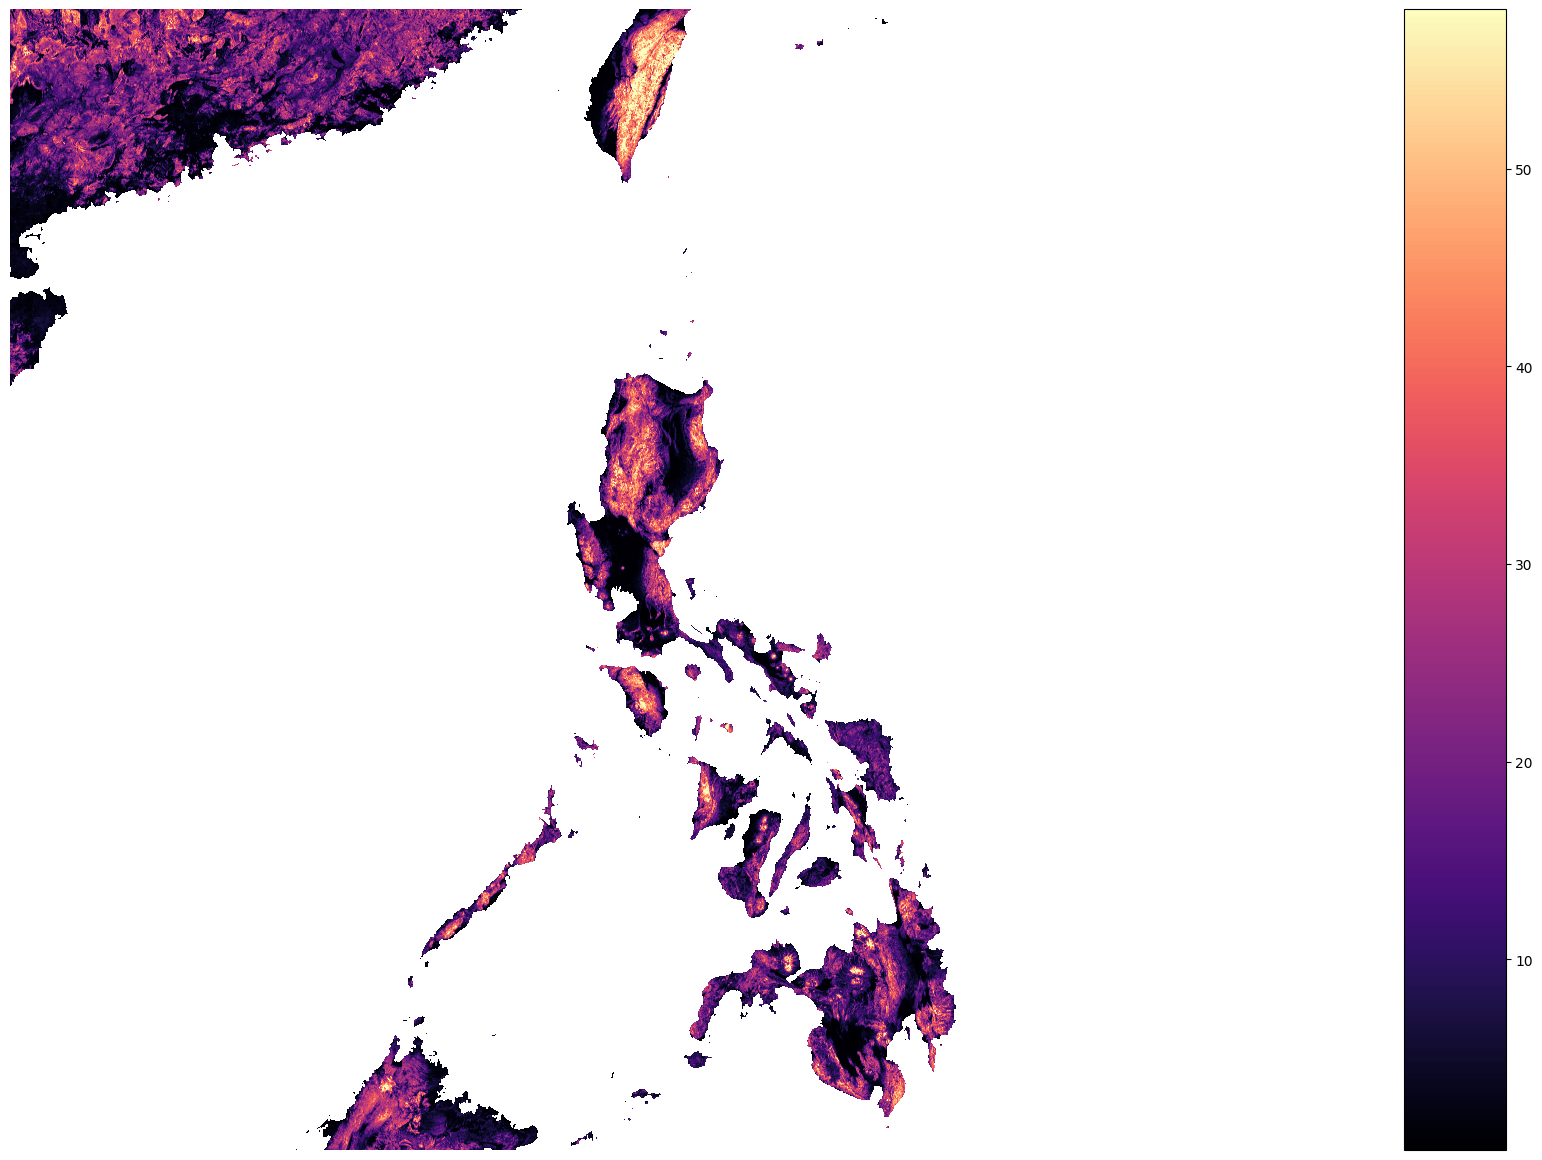

In [18]:
sp_dem = rd.rdarray(merged_array, no_data=rast.nodata)
slope = rd.TerrainAttribute(sp_dem, attrib="slope_riserun")
rd.rdShow(slope, axes=False, cmap="magma", figsize=(20, 12))
plt.show()

In [22]:
profile = merged_rast.profile
profile["nodata"] = -9999.0
profile["dtype"] = slope.dtype
with rasterio.open(input_dir / "phl_slope.tif", "w", **profile) as dst:
    dst.write(slope, 1)

### Mean Slope and Deviation

In [48]:
# computing stats
# checking if crs are the same
summary_stats = zonal_stats(
    grid,
    slope,
    stats=["mean", "std"],
    nodata=-9999,
    all_touched=True,
    affine=merged_rast.transform,
)
grid_slope = pd.DataFrame(summary_stats)
grid_slope_df = pd.concat([grid, grid_slope], axis=1)
grid_slope_df

,id,Longitude,Latitude,Centroid,geometry,mean,std
0,101,114.3,11.1,114.3E_11.1N,"POLYGON ((114.25000 11.15000, 114.35000 11.150...",1.646426,0.778472
1,4475,116.9,7.9,116.9E_7.9N,"POLYGON ((116.85000 7.95000, 116.95000 7.95000...",2.554344,1.717123
2,4639,117.0,8.2,117.0E_8.2N,"POLYGON ((116.95000 8.25000, 117.05000 8.25000...",0.891803,0.481889
3,4640,117.0,8.1,117.0E_8.1N,"POLYGON ((116.95000 8.15000, 117.05000 8.15000...",3.429532,4.395533
4,4641,117.0,8.0,117.0E_8.0N,"POLYGON ((116.95000 8.05000, 117.05000 8.05000...",5.783722,6.658342
...,...,...,...,...,...,...,...
3721,20677,126.6,7.6,126.6E_7.6N,"POLYGON ((126.55000 7.65000, 126.65000 7.65000...",6.197061,7.007283
3722,20678,126.6,7.5,126.6E_7.5N,"POLYGON ((126.55000 7.55000, 126.65000 7.55000...",5.741443,5.002396
3723,20679,126.6,7.4,126.6E_7.4N,"POLYGON ((126.55000 7.45000, 126.65000 7.45000...",7.215598,4.326641
3724,20680,126.6,7.3,126.6E_7.3N,"POLYGON ((126.55000 7.35000, 126.65000 7.35000...",9.501357,7.088974


## Mean Elevation

In [16]:
# computing stats
# checking if crs are the same
summary_stats = zonal_stats(
    grid,
    merged_array,
    stats=["mean"],
    nodata=-32768,
    all_touched=True,
    affine=merged_rast.transform,
)
grid_elev = pd.DataFrame(summary_stats)
grid_elev_df = pd.concat([grid, grid_elev], axis=1)
grid_elev_df 

## Ruggedness

### Mean ruggedness

### Ruggedness deviation

## Area in Square Kilometers

## Coast

### With Coast

### Coast Length